# Ensemble Classifiers for Footprinting
## One TF at a time

In [2]:
libs <- c(
    'RColorBrewer',
    'ggplot2',
    'xgboost',
    'glmnet',
    'dplyr',
    'tidyr',
    'pROC',
    'stringr',
    'caret',
    'caTools'
)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

(.packages())

[1] "caTools"      "caret"        "lattice"      "stringr"      "pROC"        
 [6] "tidyr"        "dplyr"        "glmnet"       "foreach"      "Matrix"      
[11] "xgboost"      "ggplot2"      "RColorBrewer" "stats"        "graphics"    
[16] "grDevices"    "utils"        "datasets"     "methods"      "base"

In [3]:
split_data <- function(outcomes,p=0.75) {
    n <- length(outcomes)
    s <- floor(p*n)
    sample_inds <- sample(seq_len(n), size = s)
    return(sample_inds)
}

In [4]:
mattcc <- function(true_classes, predicted_classes) {
        
    pos <- true_classes == 1
    neg <- true_classes == 0
    
    TP <- as.numeric(sum( predicted_classes[pos] == true_classes[pos] ))
    TN <- as.numeric(sum( predicted_classes[neg] == true_classes[neg] ))
    FP <- as.numeric(sum( predicted_classes[pos] != true_classes[pos] ))
    FN <- as.numeric(sum( predicted_classes[neg] != true_classes[neg] )) 
    
    N1 <- TP*TN
    N2 <- FP*FN
    D1 <- TP+FP
    D2 <- TP+FN
    D3 <- TN+FP
    D4 <- TN+FN
    
    N <- N1-N2
    D <- D1*D2*D3*D4
    
    if (D==0) {
        M <- 0
    } else {
        M <- N/sqrt(D)
    }
    
    return(M)
}

mattcc.curve <- function(true.values, pred.probs, num.points=101) {
    threshholds <- seq(from=0, to=1, length.out=num.points)
    thresh.inds <- 1:length(threshholds)

    mattcc.data <- sapply(thresh.inds,
                      function(t) mattcc(true.values,as.numeric(pred.probs>threshholds[t]))
                   )
    return(mattcc.data)
}

In [5]:
ggplotColours <- function(n = 6, h = c(0, 360) + 15){
  if ((diff(h) %% 360) < 1) h[2] <- h[2] - 360/n
  hcl(h = (seq(h[1], h[2], length = n)), c = 100, l = 65)
} 

## Load data

In [68]:
# paul's data frame

# tableName <- "ftClean.Fri.Sep.30.2016-18:02:21.RData"
tableName <- "chr19.all.RData"
directory <- "~/git-repos/BDDS/trenadb/featureTable/lymphoblast"
fullPath <- file.path(directory, tableName)
stopifnot(file.exists(fullPath))
load(fullPath)

# name of big data table
ft.clean <- tbl


# cory's motif to tf-class mapping
tf.fams.file <- "/local/Cory/for_Paul/motif_class_fam"
tf.fams.table <- read.delim(tf.fams.file, stringsAsFactors=FALSE)

# mapping from tf names to motif names
tf.motif.table <- read.csv("/local/sament/tfbs/human_brain/motif_to_tf_mappings_with_tfclass.csv")
named.motifs <- tf.motif.table$motif
names(named.motifs) <- tf.motif.table$tfs
named.motifs <- named.motifs[sort(names(named.motifs))]

named.tfs <- names(named.motifs)
names(named.tfs) <- named.motifs

## Add TF classes as features

In [7]:
# check overlap of motif names from cory and paul

motif.names.from.cory <- str_replace_all(string=tf.fams.table$ID, pattern="[[:space:]]", repl="")
motif.names.from.paul <- unique(ft.clean$motif)

# motifs not occurring from sample data
from.cory.not.in.paul <- motif.names.from.cory[!(motif.names.from.cory %in% motif.names.from.paul)]

# motifs not mapped in cory's table
from.paul.not.in.cory <- motif.names.from.paul[!(motif.names.from.paul %in% motif.names.from.cory)]

# number of motifs that i'll use
from.paul.in.cory <- sort(motif.names.from.paul[(motif.names.from.paul %in% motif.names.from.cory)])
length(from.paul.in.cory)

[1] 510

In [8]:
# filter out the motifs in pauls' table that cory doesn' have tf classes for

ft.clean.corymotifs <- ft.clean %>% filter(motif %in% from.paul.in.cory)
# str(ft.clean.corymotifs)

In [9]:
# find unique tf class names from cory's list

class.names.nospaces <- str_replace_all(string=tf.fams.table$class, pattern="[[:space:]]", repl="")
unique.class.names.nospaces <- unique(class.names.nospaces)
double.entry.classes <- grep('::', unique.class.names.nospaces, value=TRUE)
dedoubled.classes <- unique(unlist(strsplit(double.entry.classes,'::')))

class.names.nospaces.minus.doubles <- unique.class.names.nospaces[!(unique.class.names.nospaces %in% double.entry.classes)]
class.names.final <- sort(unique(c(class.names.nospaces.minus.doubles,dedoubled.classes)))
length(class.names.final)

[1] 30

In [10]:
# cory's map: arrange so grepping on class column will yeild matches from paul's names

tf.fams.table.renamed <- tf.fams.table
tf.fams.table.renamed$ID <- str_replace_all(string=tf.fams.table.renamed$ID, pattern="[[:space:]]", repl="")
tf.fams.table.renamed <- tf.fams.table.renamed %>% filter(ID %in% from.paul.in.cory)
rownames(tf.fams.table.renamed) <- tf.fams.table.renamed$ID
tf.class.foreach.motif <- tf.fams.table.renamed[,-c(1)]

tf.class.foreach.motif$class <- str_replace_all(string=tf.class.foreach.motif$class, pattern="[[:space:]]", repl="")

In [11]:
# make sparse class / tf feature matrix map
# all zeros to start, fill in ones below
tf.motif.class.matrix <- matrix(0L, nrow = length(from.paul.in.cory), ncol = length(class.names.final))
rownames(tf.motif.class.matrix) <- from.paul.in.cory
colnames(tf.motif.class.matrix) <- class.names.final

# loop through tfs and classes to fill in ones where there is a match

for (tf.name in rownames(tf.motif.class.matrix)) {
    for (class.name in colnames(tf.motif.class.matrix)) {
        class.to.check <- tf.class.foreach.motif[tf.name,'class']
        classes.match <- any(grep(class.name, class.to.check, value=FALSE, fixed=TRUE))
        if (classes.match == 1) {
            tf.motif.class.matrix[tf.name,class.name] <- 1
        }
    }
    
}

In [12]:
# number of motifs with extra entries is small:
dim(tf.motif.class.matrix)
sum(tf.motif.class.matrix)

# check to see if any motifs didn't match
rownames(tf.motif.class.matrix)[rowSums(tf.motif.class.matrix) == 0]

[1] 510  30

[1] 513

character(0)

In [13]:
# tf class distribution
# colSums(tf.motif.class.matrix)

In [14]:
# merging is a way saner way to... merge dataframes, who knew?
tf.motif.class.df <- as.data.frame(tf.motif.class.matrix)
tf.motif.class.df$motif <- rownames(tf.motif.class.df)
dim(tf.motif.class.df)

ft.clean.corymotifs.tfclasses <- merge(ft.clean.corymotifs, tf.motif.class.df, by="motif", all.x=TRUE)
dim(ft.clean.corymotifs.tfclasses)

[1] 510  31

[1] 912159     41

In [15]:
# check to see if any loc/motifs didn't get a class
rownames(ft.clean.corymotifs.tfclasses)[rowSums(ft.clean.corymotifs.tfclasses[,colnames(tf.motif.class.matrix)]) == 0]

character(0)

In [16]:
# most entries just have one class
dim(ft.clean.corymotifs.tfclasses[,colnames(tf.motif.class.matrix)])[1]
sum(ft.clean.corymotifs.tfclasses[,colnames(tf.motif.class.matrix)])

[1] 912159

[1] 915394

## Functions for analyzing models

### Functions for predicting from models and gathering statistics

In [17]:
# make dataframe for preditions vs ChIPseq
make.pred.df.from.model <- function(gbdt.model,X.testdata,y.testdata) {
    
    preds.test <- predict(gbdt.model, X.testdata, missing=NA)
    pred.df <- data.frame("ChIPseq.bound"=y.testdata,"Prediction"=preds.test)
    pred.df$Model.Name = gbdt.model$Model.Name
    return(pred.df)
    
}

make.pred.df.from.glm <- function(glm.model,df.testdata) {
    
    preds.test <- predict.glm(object=glm.model, newdata=df.testdata, type="response")
    pred.df <- data.frame("ChIPseq.bound"=df.testdata$CHIPseq.bound,"Prediction"=preds.test)
    pred.df$Model.Name = glm.model$Model.Name
    return(pred.df)
    
}

# compute roc curve and prec/recall-like stats
make.stats.df.from.preds <- function(pred.df, num.roc.points=101) {
    
    preds <- pred.df$Prediction
    cs.vals <- pred.df$ChIPseq.bound

    roc.tf <- roc(cs.vals, preds,
                  ret=c("threshold", "sens", "spec", "ppv", "npv", "acc"))
    stats.tf <- coords((roc.tf),
       seq(from=0, to=1, length.out=num.roc.points),
       ret=c("threshold", "sens", "spec", "ppv", "npv", "acc"))
    mattcc.tf <- mattcc.curve(cs.vals, preds, num.points=num.roc.points)
    df.stats <- as.data.frame(t(stats.tf))
    df.stats$MattCC <- mattcc.tf
    df.stats$Model.Name <- pred.df$Model.Name[1]
    
    return(df.stats)
}

### Functions for plotting ROC curves and the like

In [45]:
plot.roc.curve <- function(stat.dataframe, printAUC=FALSE, per.TF=FALSE) {
    
    if (printAUC == TRUE){
        specif.sense.df <- stat.dataframe[,c("specificity","sensitivity")]
        ordered.specif.sense.df <- specif.sense.df[with(specif.sense.df, order(specificity)), ]
        ss.x <- ordered.specif.sense.df$specificity
        ss.y <- ordered.specif.sense.df$sensitivity
        AUC <- trapz(ss.x,ss.y)
    }
    
    p <- ggplot(stat.dataframe) +
    geom_line(aes(x=specificity, y=sensitivity, color=Model.Name)) +
    geom_abline(intercept = 1, slope = 1, color='lightgrey') +
    scale_x_reverse(lim=c(1,0)) + scale_y_continuous(lim=c(0,1)) +
    coord_fixed(ratio=1) +
    labs(x="Specificity", y="Sensitivity") +
    theme_minimal()
    if (printAUC == TRUE) {
        p <- p + annotate("text", x=0.25, y=0.2, label=paste('AUC = ', format(AUC,digits=5), sep=''))
    }
    if (per.TF == TRUE) {
        p <- p + labs(title=attr(stats.allmodels.df, "TF")) + 
        annotate("text", x=0.25, y=0.4, label=paste('Number of test points = ', attr(stats.allmodels.df, "Test.Points"), sep=''))   
    }
    p
}

plot.precrecall.curve <- function(stat.dataframe, per.TF=FALSE) {
    p <- ggplot(stat.dataframe) + 
    geom_line(aes(x=sensitivity, y=ppv, color=Model.Name)) + 
    scale_x_continuous(lim=c(0,1)) + scale_y_continuous(lim=c(0,1)) +
    coord_fixed(ratio=1) +
    labs(x="Precision", y="Recall") +
    theme_minimal()
    if (per.TF == TRUE) {
        p <- p + labs(title=attr(stats.allmodels.df, "TF")) + 
        annotate("text", x=0.75, y=0.95, label=paste('Number of test points = ', attr(stats.allmodels.df, "Test.Points"), sep=''))   
    }
    p
}

plot.mattcc.curve <- function(stat.dataframe, per.TF=FALSE) {
    p <- ggplot(stat.dataframe) +
    geom_line(aes(x=threshold, y=MattCC, color=Model.Name)) +
    scale_x_continuous(lim=c(0,1)) + scale_y_continuous(lim=c(0,1)) +
    coord_fixed(ratio=1) +
    labs(x="Threshold", y="Matthews correlation coefficient") +
    theme_minimal()
    if (per.TF == TRUE) {
        p <- p + labs(title=attr(stats.allmodels.df, "TF")) + 
        annotate("text", x=0.75, y=0.95, label=paste('Number of test points = ', attr(stats.allmodels.df, "Test.Points"), sep=''))   
    }
    p
    
}

plot.all.curve <- function(stat.dataframe) {
    stat.dataframe.tidy <- gather(stat.dataframe, 'Statistic', 'Value', -threshold, -Model.Name)    
    p <- ggplot(stat.dataframe.tidy) +
    geom_line(aes(x=threshold, y=Value, color=Statistic)) +
    scale_x_continuous(lim=c(0,1)) + scale_y_continuous(lim=c(0,1)) +
    coord_fixed(ratio=1) +
    labs(x="Threshold") +
    theme_minimal()
    p
}


## fucntion to make roc etc stats per tf for all models

In [38]:
make.stats.df.per.TF <- function(tf.string, ft.data.noclasses) {

    motif.string <- named.motifs[tf.string]
    TF.inds <- ft.data.noclasses$motif == motif.string
    ft.data.motif <- ft.data.noclasses[TF.inds,]

    # binarize chipseq score
    y <- as.numeric(ft.data.motif$csscore > 0)

    # drop some columns 
    cols.to.drop <- c("csscore", "csTF", "motif", "loc", "totalsamplecount")

    # drop all TF class info
    X <- as.matrix(ft.data.motif[,!(colnames(ft.data.motif) %in% cols.to.drop)])
    rownames(X) <- NULL

    # split into test and train sets
    train.inds <- split_data(y)

    X.train <- as.matrix(X[train.inds,])
    X.test <- as.matrix(X[-train.inds,])
    y.train <- y[train.inds]
    y.test <- y[-train.inds]

    # make gbdt
    param <- list("objective" = "binary:logistic",
              "max.depth" = 3,
              "eta" = 0.05,
              "eval.metric" = "auc"
              )
    gbdt.motif <- xgboost(
        params = param,
        data = X.train,
        label = y.train,
        nround = 25,
        verbose = FALSE,
        missing = NA
    )
    gbdt.motif$Model.Name <- "Trees All"
    
    # gbdt predictions and stats
    preds.test.gbdt <- predict(gbdt.motif, X.test, missing=NA)
    pred.gbdt.df <- data.frame("ChIPseq.bound"=y.test,"Prediction"=preds.test.gbdt)
    pred.gbdt.df$Model.Name = gbdt.motif$Model.Name
    stats.gbdt.df <- make.stats.df.from.preds(pred.gbdt.df, num.roc.points=1001)

    # make glm using all features
    all.regressors <- paste(colnames(X.train), collapse=" + ")
    glm.formula <- paste("CHIPseq.bound ~ ", all.regressors, sep='')
    glm.df.train <- as.data.frame(cbind("CHIPseq.bound"=y.train, X.train))
    glm.df.test <- as.data.frame(cbind("CHIPseq.bound"=y.test, X.test))
    glm.motif <- glm(as.formula(glm.formula), data=glm.df.train, family=binomial)
    glm.motif$Model.Name <- "GLM All"

    # glm predictions and stats
    preds.test.glm <- predict.glm(object=glm.motif, newdata=glm.df.test, type="response")   
    pred.glm.df <- data.frame("ChIPseq.bound"=glm.df.test$CHIPseq.bound,"Prediction"=preds.test.glm)
    pred.glm.df$Model.Name = glm.motif$Model.Name
    stats.glm.df <- make.stats.df.from.preds(pred.glm.df, num.roc.points=1001)
        
    # make glm using individual features
    all.regressors <- paste(colnames(X.train), collapse=" + ")
    glm.formula <- paste("CHIPseq.bound ~ ", all.regressors, sep='')
    glm.df.train <- as.data.frame(cbind("CHIPseq.bound"=y.train, X.train))
    glm.df.test <- as.data.frame(cbind("CHIPseq.bound"=y.test, X.test))
    glm.motif <- glm(as.formula(glm.formula), data=glm.df.train, family=binomial)
    glm.motif$Model.Name <- "GLM All"

    # glm predictions and stats
    preds.test.glm <- predict.glm(object=glm.motif, newdata=glm.df.test, type="response")   
    pred.glm.df <- data.frame("ChIPseq.bound"=glm.df.test$CHIPseq.bound,"Prediction"=preds.test.glm)
    pred.glm.df$Model.Name = glm.motif$Model.Name
    stats.glm.df <- make.stats.df.from.preds(pred.glm.df, num.roc.points=1001)
    
    # for each regressor individually, make a model and add the roc curve to the plot
    boilerplate <- "CHIPseq.bound ~ "
    regressors <- colnames(X.test)
    stats.regressors.df <- data.frame()
    for (i in 1:length(regressors)) {
        formula.text <- paste(boilerplate, regressors[i], sep="")
        glm.regressor <- glm(as.formula(formula.text), data=glm.df.train, family=binomial)
        glm.regressor$Model.Name <- paste("GLM", regressors[i], sep=' ')
        preds.test.glm.regressor <- predict.glm(object=glm.regressor, newdata=glm.df.test, type="response")
        pred.glm.regressor.df <- data.frame("ChIPseq.bound"=glm.df.test$CHIPseq.bound,"Prediction"=preds.test.glm.regressor)
        pred.glm.regressor.df$Model.Name = glm.regressor$Model.Name
        stats.glm.regressor.df <- make.stats.df.from.preds(pred.glm.regressor.df, num.roc.points=1001)
        stats.regressors.df <- rbind(stats.regressors.df,stats.glm.regressor.df)
    }

    # aggregate stats
    stats.all.df <- rbind(stats.regressors.df, stats.glm.df, stats.gbdt.df)
    attr(stats.all.df, "TF") = tf.string
    attr(stats.all.df, "Test.Points") = length(y.test)
    return(stats.all.df)

}

## make per-TF models

In [49]:
ft.clean.corymotifs.noclasses <- ft.clean.corymotifs.tfclasses[,c(1:11)]

### For Tfs in seth's plots

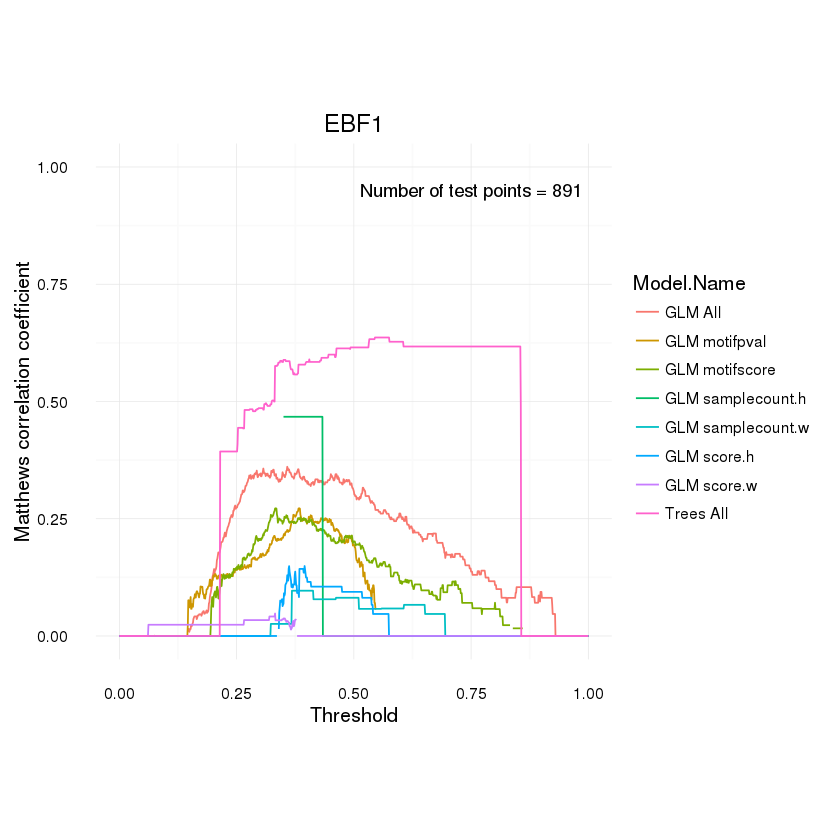

Warning message:
“Removed 2498 rows containing missing values (geom_path).”

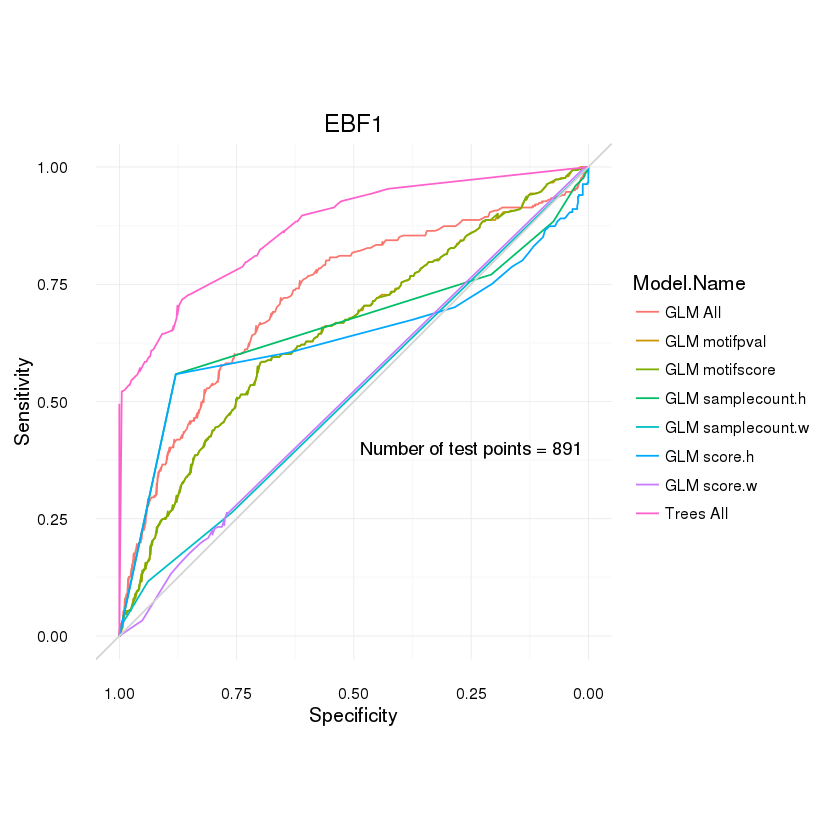

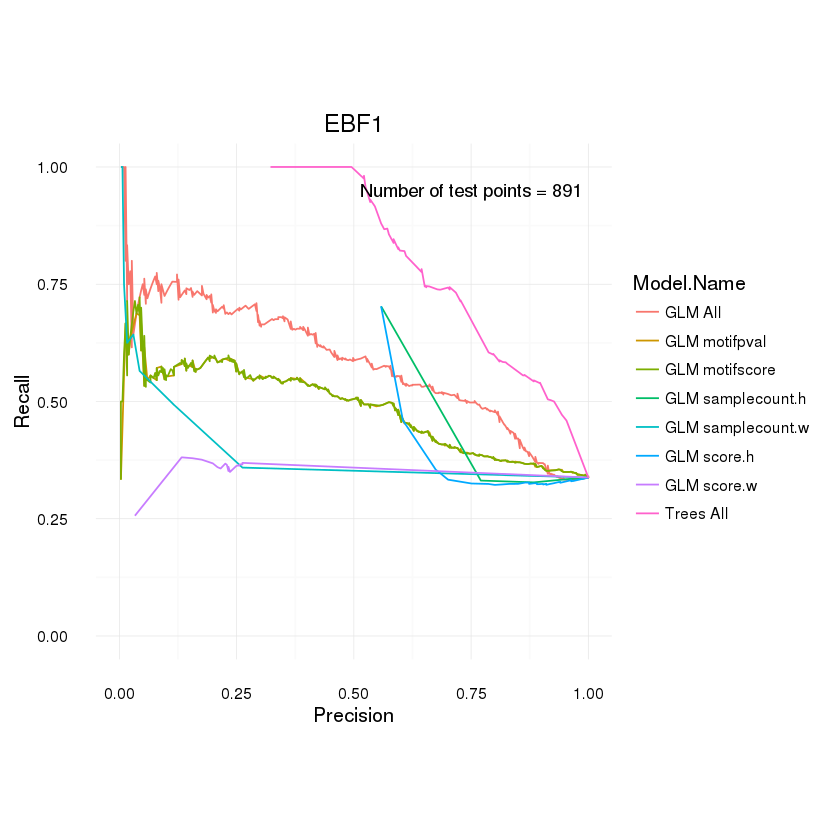

In [97]:
stats.allmodels.df <- make.stats.df.per.TF('EBF1', ft.clean.corymotifs.noclasses)
plot.mattcc.curve(stats.allmodels.df, per.TF=TRUE)
plot.roc.curve(stats.allmodels.df, per.TF=TRUE)
plot.precrecall.curve(stats.allmodels.df, per.TF=TRUE)

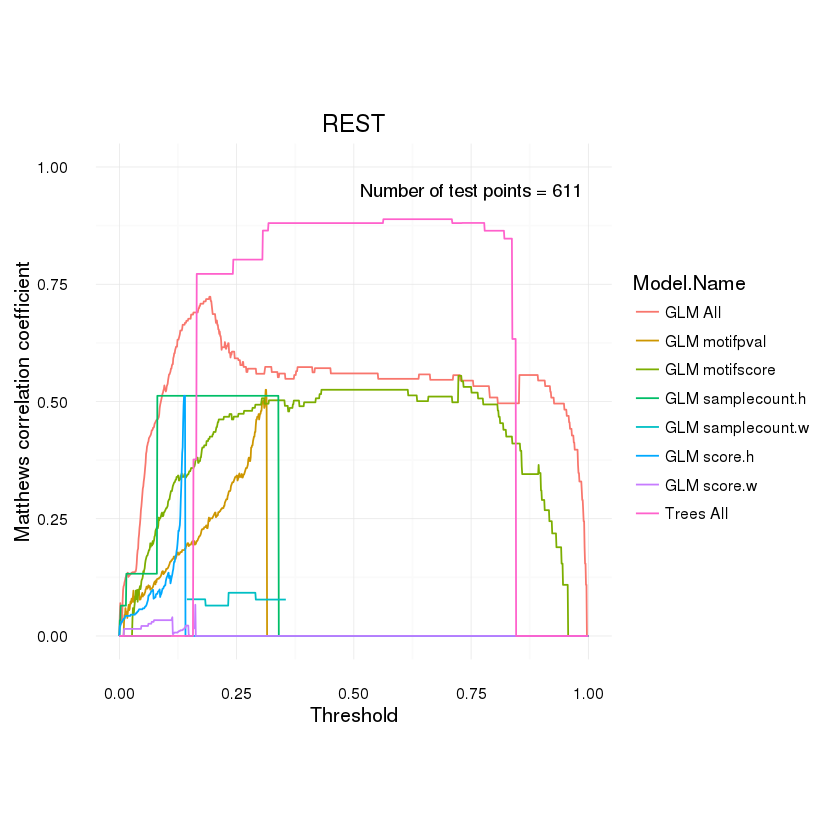

Warning message:
“Removed 3248 rows containing missing values (geom_path).”

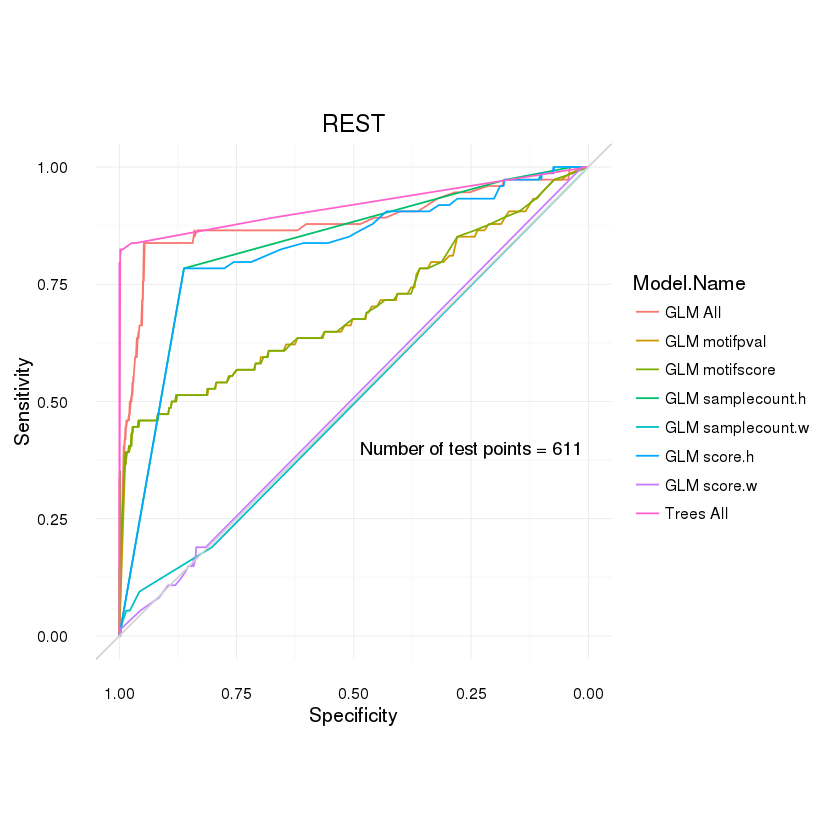

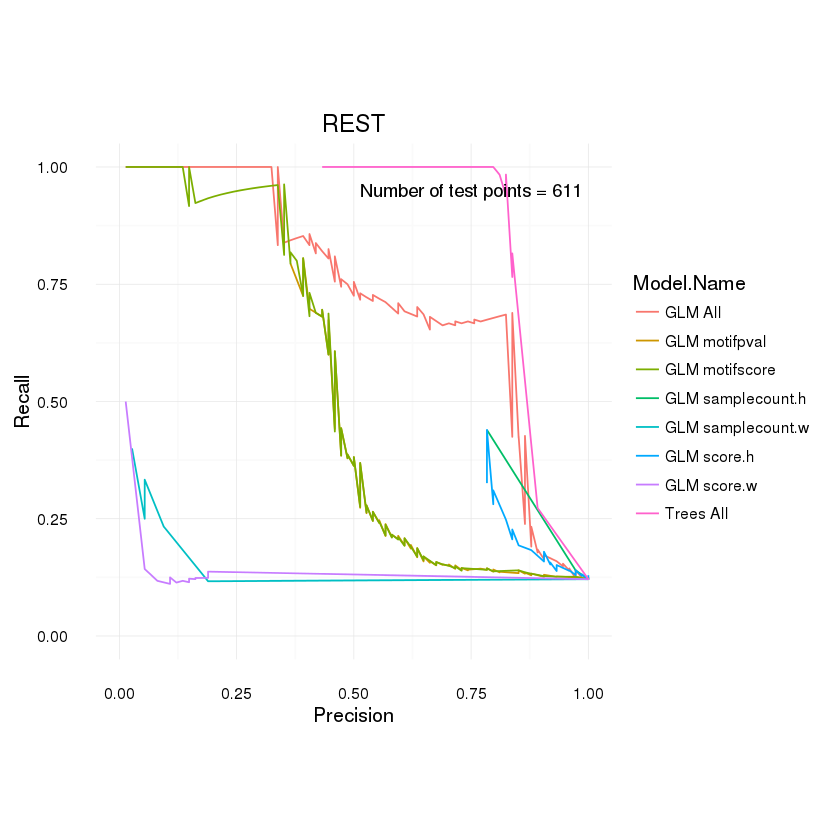

In [50]:
stats.allmodels.df <- make.stats.df.per.TF('REST', ft.clean.corymotifs.noclasses)
plot.mattcc.curve(stats.allmodels.df, per.TF=TRUE)
plot.roc.curve(stats.allmodels.df, per.TF=TRUE)
plot.precrecall.curve(stats.allmodels.df, per.TF=TRUE)

### MYC

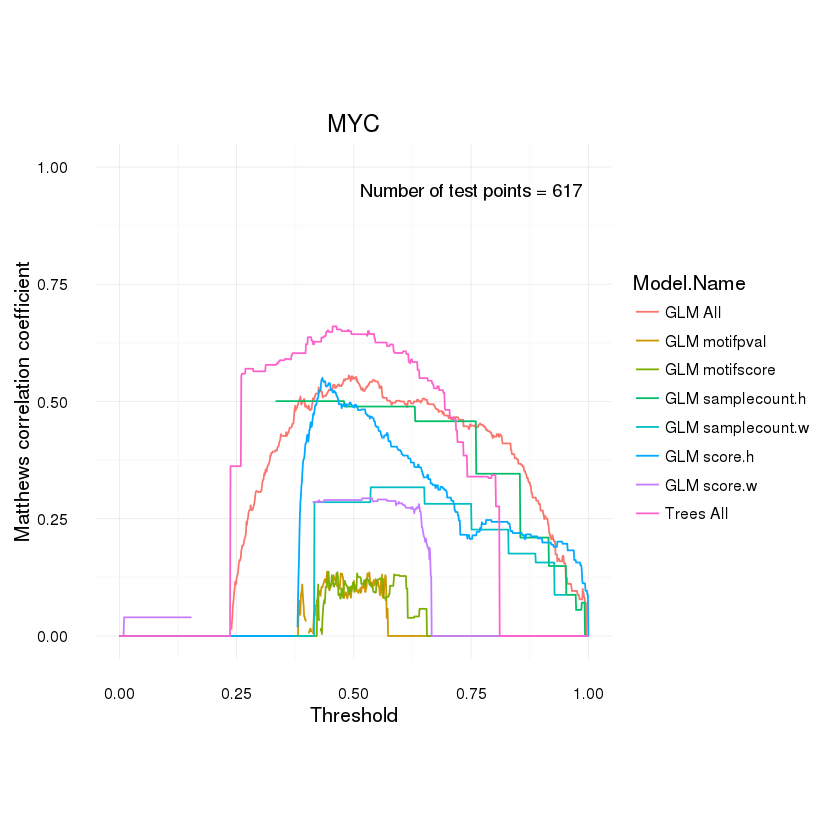

Warning message:
“Removed 1312 rows containing missing values (geom_path).”

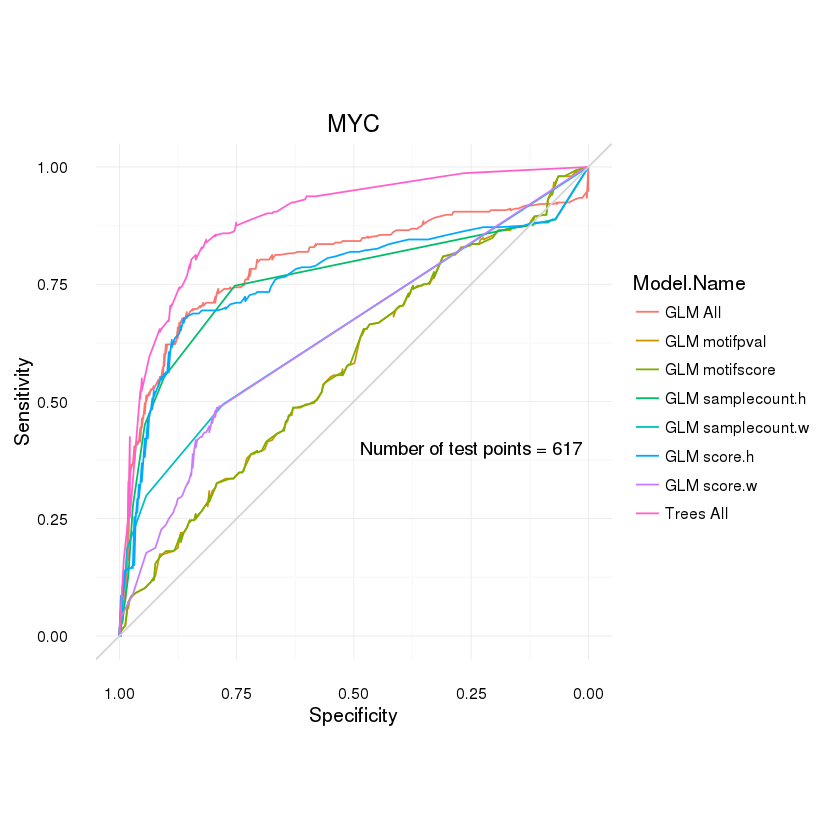

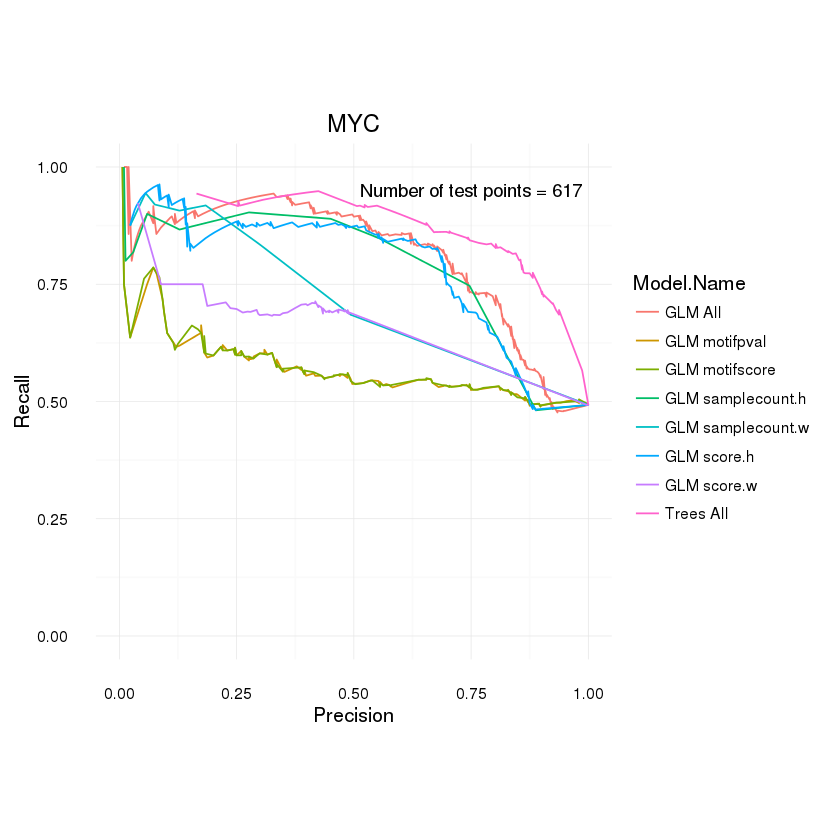

In [51]:
stats.allmodels.df <- make.stats.df.per.TF('MYC', ft.clean.corymotifs.noclasses)
plot.mattcc.curve(stats.allmodels.df, per.TF=TRUE)
plot.roc.curve(stats.allmodels.df, per.TF=TRUE)
plot.precrecall.curve(stats.allmodels.df, per.TF=TRUE)

### TFs with most data

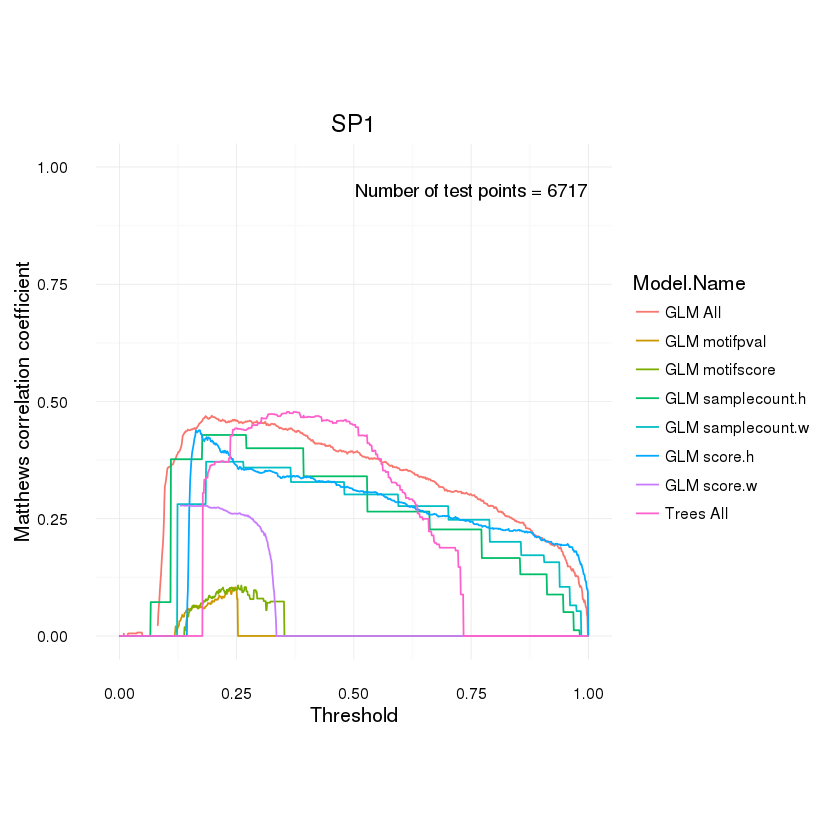

Warning message:
“Removed 2368 rows containing missing values (geom_path).”

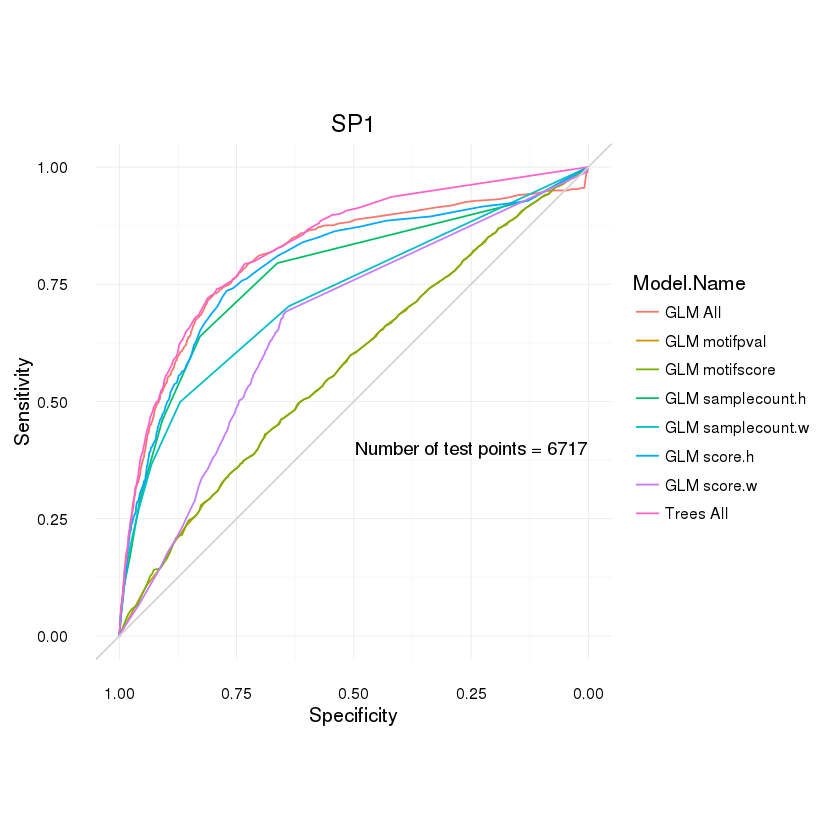

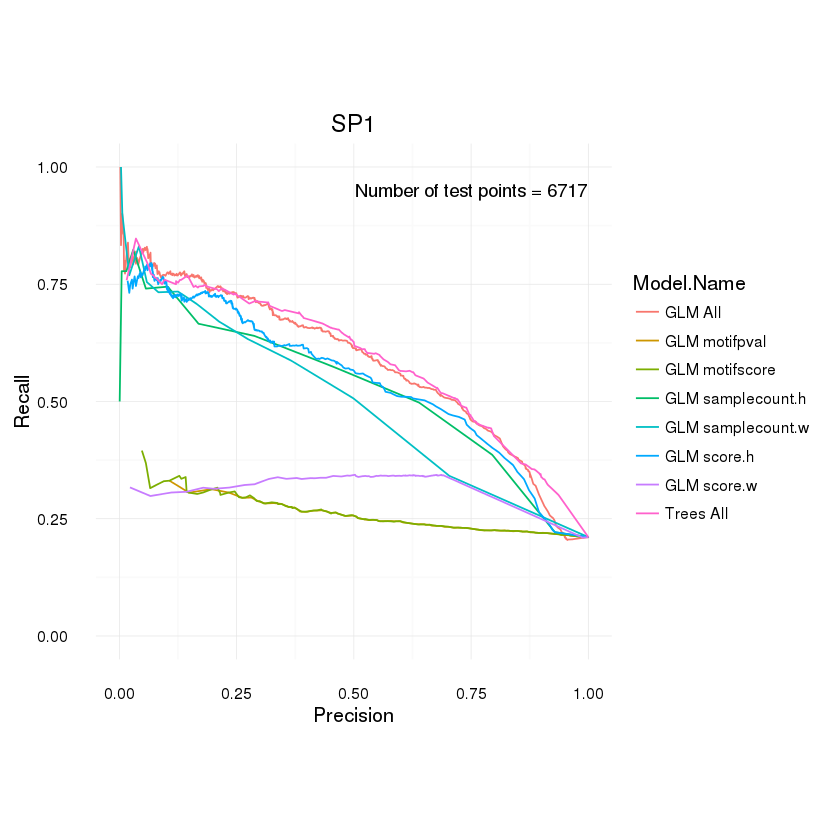

In [83]:
stats.allmodels.df <- make.stats.df.per.TF('SP1', ft.clean.corymotifs.noclasses)
plot.mattcc.curve(stats.allmodels.df, per.TF=TRUE)
plot.roc.curve(stats.allmodels.df, per.TF=TRUE)
plot.precrecall.curve(stats.allmodels.df, per.TF=TRUE)

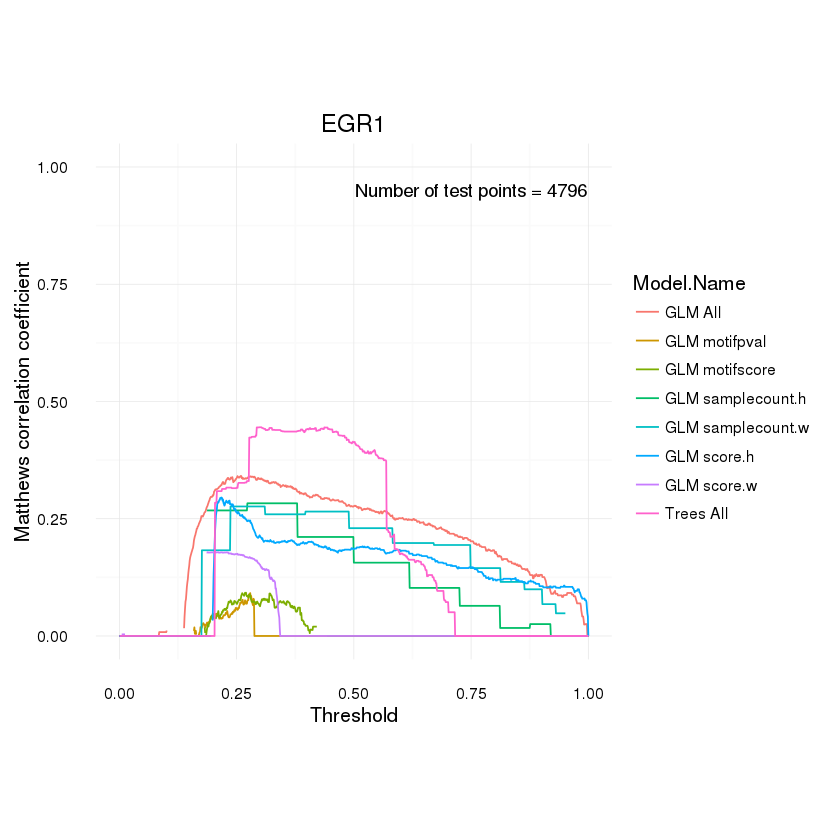

Warning message:
“Removed 2299 rows containing missing values (geom_path).”

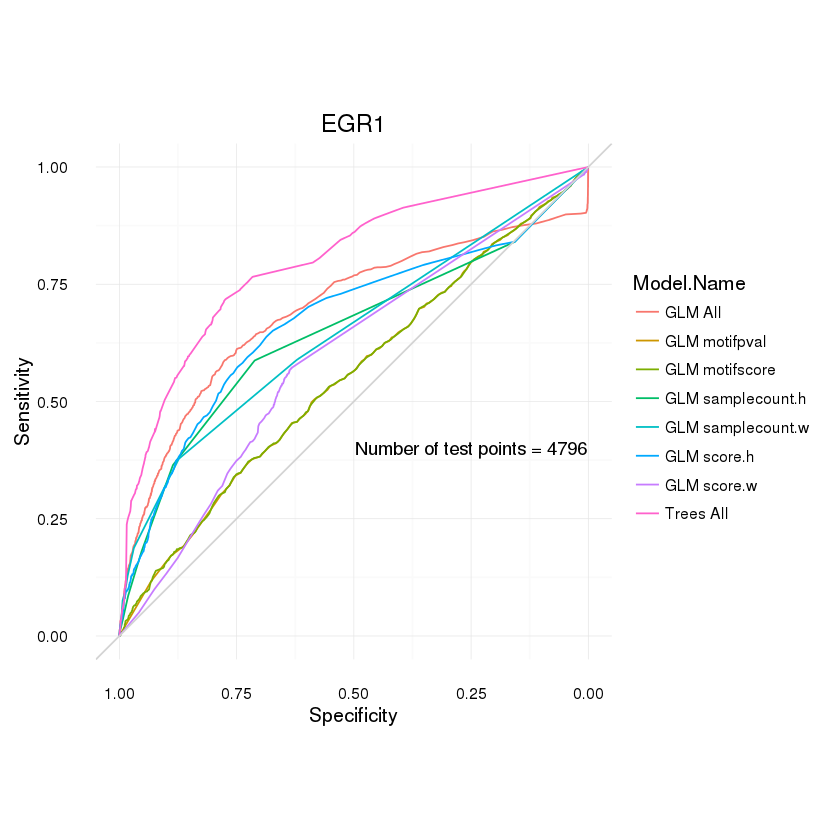

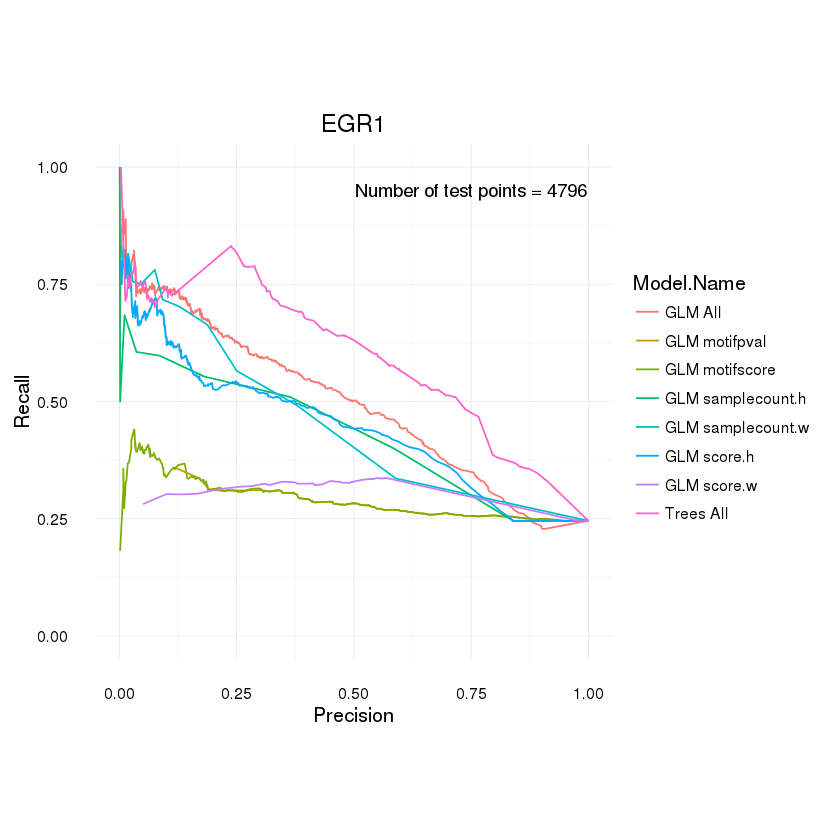

In [85]:
stats.allmodels.df <- make.stats.df.per.TF('EGR1', ft.clean.corymotifs.noclasses)
plot.mattcc.curve(stats.allmodels.df, per.TF=TRUE)
plot.roc.curve(stats.allmodels.df, per.TF=TRUE)
plot.precrecall.curve(stats.allmodels.df, per.TF=TRUE)

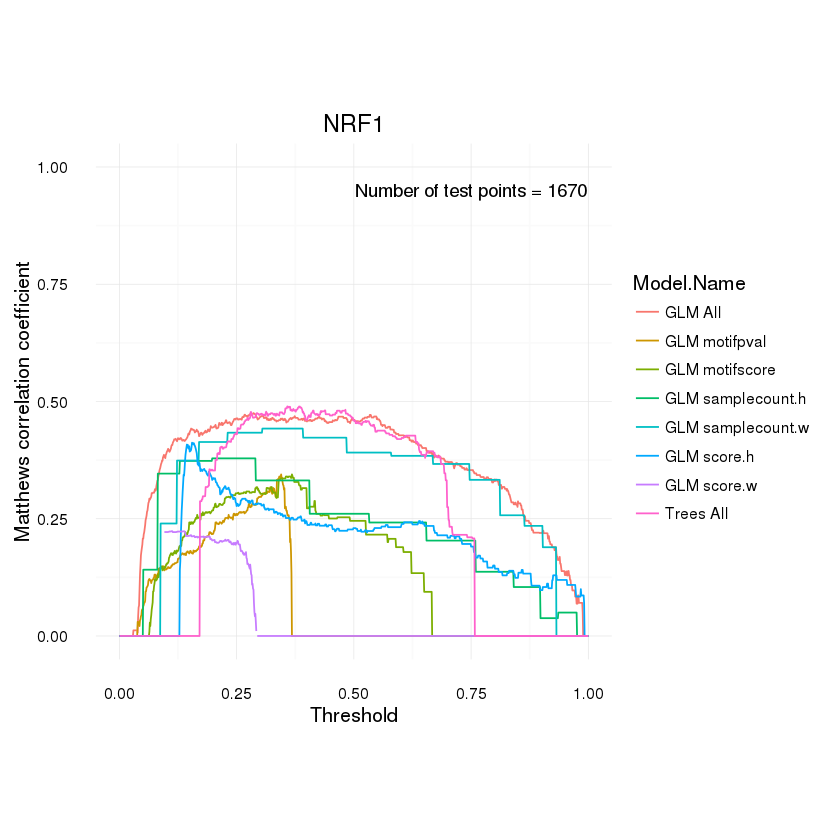

Warning message:
“Removed 2032 rows containing missing values (geom_path).”

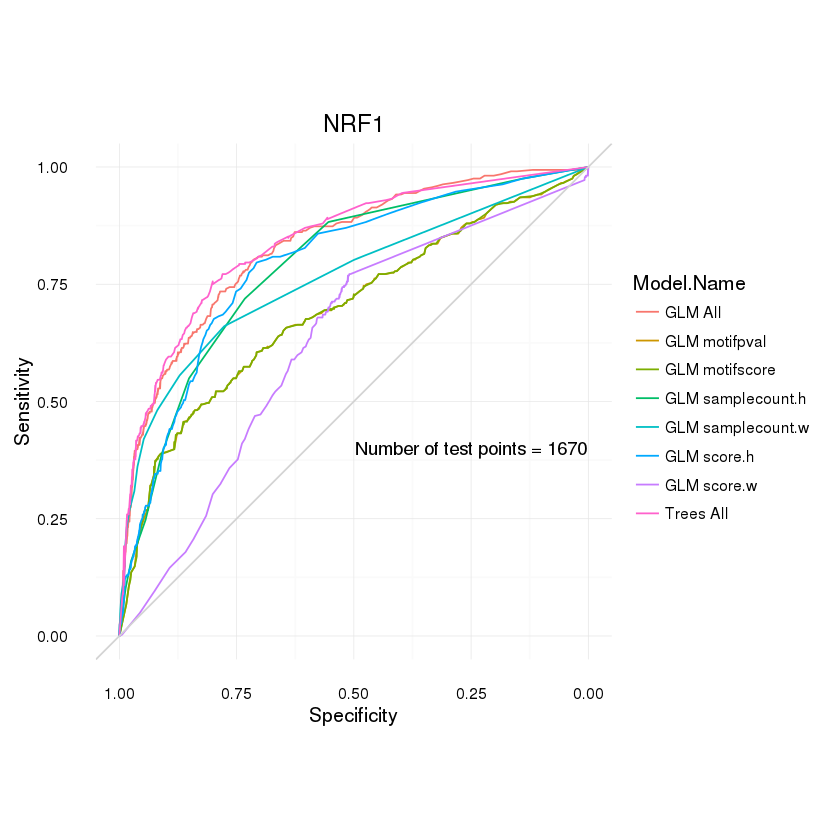

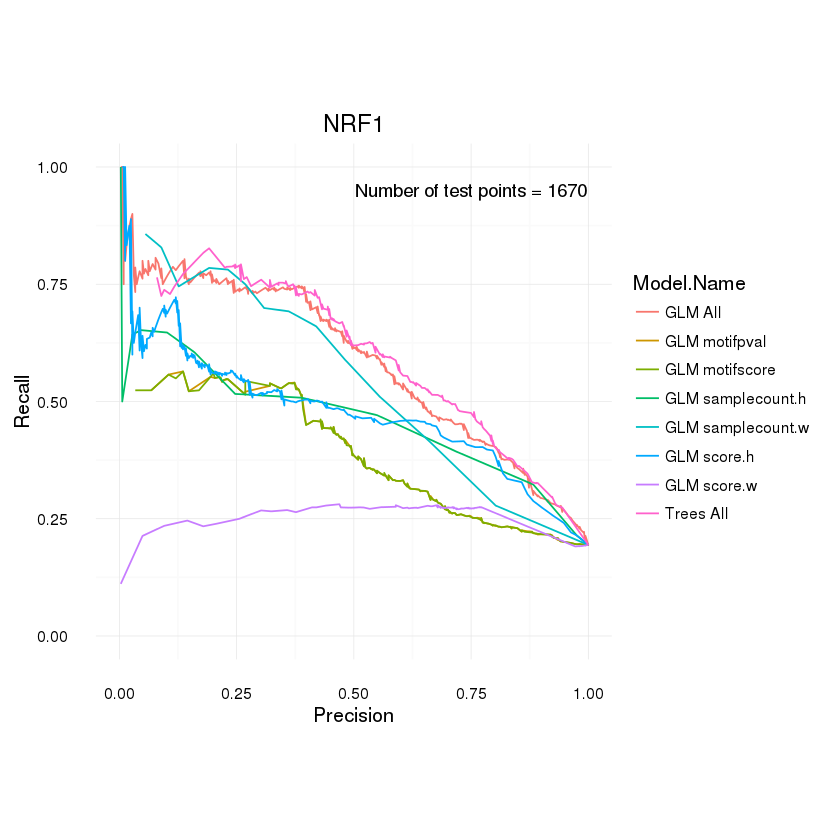

In [86]:
stats.allmodels.df <- make.stats.df.per.TF('NRF1', ft.clean.corymotifs.noclasses)
plot.mattcc.curve(stats.allmodels.df, per.TF=TRUE)
plot.roc.curve(stats.allmodels.df, per.TF=TRUE)
plot.precrecall.curve(stats.allmodels.df, per.TF=TRUE)

In [74]:
motifs.most.data <- head(sort(table(ft.clean.corymotifs.noclasses$motif), decreasing = TRUE), 25)
named.tfs[names(motifs.most.data)]

MA0079.3 MA0516.1 MA0599.1 MA0528.1 MA0741.1 MA0746.1 MA0162.2 MA0039.2 
   "SP1"    "SP2"   "KLF5" "ZNF263"  "KLF16"    "SP3"   "EGR1"  "KLF10" 
MA0747.1 MA0753.1 MA0163.1 MA0073.1 MA0493.1 MA0685.1 MA0740.1 MA0146.2 
   "SP8" "ZNF740"  "PLAG1"  "RREB1"   "KLF1"    "SP4"  "KLF14"    "ZFX" 
    <NA> MA0732.1     <NA> MA0471.1 MA0733.1 MA0742.1 MA0506.1     <NA> 
      NA   "EGR3"       NA   "E2F6"   "EGR4"  "KLF12"   "NRF1"       NA 
MA0504.1 
 "NR2C1"